### GPT model from transformers

In [ ]:
%%bash
cd ..


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
from transformers import GPT2LMHeadModel

print model state dict

In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

### Visualize transformer positional embedding layer

In [4]:
# view weights
sd_hf["transformer.wpe.weight"].view(-1)[:20]


tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

Matplotlib is building the font cache; this may take a moment.


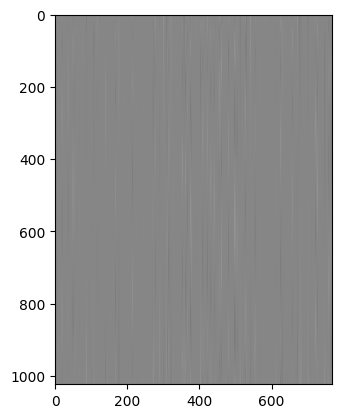

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

plot of 3 weight channels in positional embedding

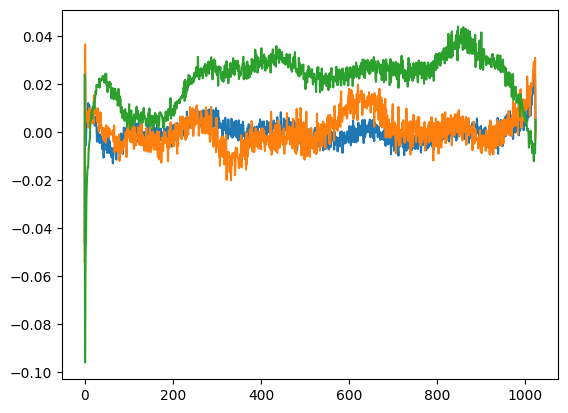

In [7]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

### attention layer

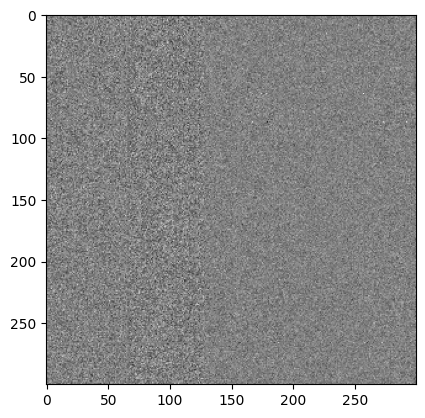

In [12]:
plt.imshow(sd_hf["transformer.h.5.attn.c_attn.weight"][:300,:300], cmap="gray")


### generate text

In [39]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2', device='mps')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use mps
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, and my project will get better with time, but I think there are a lot more things that can help you"},
 {'generated_text': "Hello, I'm a language model, not a language model, so if I don't have a problem, I can fix it by creating new words"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to learn some stuff. I'll try to do some basic programming and just learn better ways"},
 {'generated_text': "Hello, I'm a language model, but I don't believe in grammar. This will work for every language model. You can define it very quickly"},
 {'generated_text': 'Hello, I\'m a language model, a model of how things should be, and then we look at different things as well." I\'d like to'}]

Generate manually to compare with our implementation

In [42]:
# let's instead sample manually
import torch
from torch.nn import functional as F

def generated_seq(model):
    device = 'mps'
    model.eval()
    model.to(device)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
    tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
    tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
    x = tokens.to(device)

    # generate!
    while x.size(1) < 30: # max_length=30
        # forward the model to get the logits
        with torch.no_grad():
            logits = model(x)[0] # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            x = torch.cat((x, xcol), dim=1)

    # print the generated text
    import tiktoken
    enc = tiktoken.get_encoding('gpt2')
    for i in range(5):
        tokens = x[i, :30].tolist()
        decoded = enc.decode(tokens)
        print(">", decoded)

In [43]:
print("HF model")
hf_model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
generated_seq(hf_model)

HF model
> Hello, I'm a language model, which means I'm familiar with it, but I'm not fluent in that. Well, with that said,
> Hello, I'm a language model, and the syntax, to make use of it, is pretty good. So why do you have that and not
> Hello, I'm a language model, I'm doing this work in Python, and then I'm writing code for Haskell.

So we can
> Hello, I'm a language model, and you're making assumptions about my use of them. I'm not a natural language learner. I'm
> Hello, I'm a language model, well, I'm from Java and have to write a programming language for it. I have my own vocabulary because


In [46]:
print("My model")
from gpt2 import GPT

my_model = GPT.from_pretrained('gpt2')
generated_seq(my_model)

My model


ModuleNotFoundError: No module named 'gpt2'